In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasssss/balanced_creditcard_data.csv


In [3]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 51.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 76.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 4.2.4
    Uninstalling cachetools-4.2.4:
      Successfully uninstalled cachetools-4.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, 

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, SimpleRNN, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
import shap  # For model interpretability
import lime  # Optionally, if using LIME for interpretability
import lime.lime_tabular
import mlflow  # For experiment tracking
import mlflow.keras  # To log Keras models with MLflow
import logging  # For logging
import pandas as pd
from tensorflow.keras.layers import Dense, Conv1D, Flatten, SimpleRNN, LSTM, Dropout, Input  # Add Input here
from tensorflow.keras.utils import to_categorical


# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ModelEvaluator:
    def __init__(self, csv_path, target_column):
        logging.info("Initializing ModelEvaluator")
        self.data = pd.read_csv(csv_path)
        self.target_column = target_column
        self.X = self.data.drop(columns=[target_column])
        self.y = to_categorical(self.data[target_column])  # for categorical target
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        self.results = {}
    
    def build_mlp(self, output_shape):
        logging.info("Building MLP model")
        model = Sequential([
            Input(shape=(self.X.shape[1],)),  # Input layer
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dense(output_shape, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def build_cnn(self, output_shape):
        logging.info("Building CNN model")
        model = Sequential([
            Input(shape=(self.X.shape[1], 1)),  # Input layer
            Conv1D(64, kernel_size=3, activation='relu'),
            Flatten(),
            Dense(output_shape, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def build_rnn(self, output_shape):
        logging.info("Building RNN model")
        model = Sequential([
            Input(shape=(self.X.shape[1], 1)),  # Input layer
            SimpleRNN(64, activation='relu'),
            Dense(output_shape, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def build_lstm(self, output_shape):
        logging.info("Building LSTM model")
        model = Sequential([
            Input(shape=(self.X.shape[1], 1)),  # Input layer
            LSTM(64, activation='relu'),
            Dense(output_shape, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train_model(self, model, model_name):
        logging.info(f"Training model: {model_name}")
        mlflow.start_run(run_name=model_name)
        mlflow.keras.autolog()  # Automatically log metrics and model
        
        # Train the model and set verbose=1 to print each epoch
        history = model.fit(
            self.X_train, self.y_train,
            epochs=10, batch_size=32, validation_split=0.2, verbose=1
        )
        
        for epoch in range(len(history.history['accuracy'])):
            accuracy = history.history['accuracy'][epoch]
            val_accuracy = history.history['val_accuracy'][epoch]
            loss = history.history['loss'][epoch]
            val_loss = history.history['val_loss'][epoch]
            
            logging.info(f"Epoch {epoch + 1}: "
                         f"accuracy={accuracy:.4f}, val_accuracy={val_accuracy:.4f}, "
                         f"loss={loss:.4f}, val_loss={val_loss:.4f}")
            
            mlflow.log_metric("accuracy", accuracy, step=epoch)
            mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)
            mlflow.log_metric("loss", loss, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)

        mlflow.end_run()  # End the MLflow run
        logging.info(f"Training completed for model: {model_name}")
        return model
    
    def evaluate_model(self, model, model_name):
        logging.info(f"Evaluating model: {model_name}")
        y_pred = np.argmax(model.predict(self.X_test), axis=1)
        y_true = np.argmax(self.y_test, axis=1)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        self.results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        
        # Log evaluation metrics with MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        logging.info(f"Model evaluation completed for {model_name}")
    
    def explain_model(self, model, model_name):
        logging.info(f"Explaining model: {model_name}")
        explainer = shap.KernelExplainer(model.predict, self.X_test[:100])  # Reduce test size for performance
        shap_values = explainer.shap_values(self.X_test[:100])
        shap.summary_plot(shap_values, self.X_test[:100], plot_type="bar", show=False)
        logging.info(f"Explainability summary for {model_name} generated.")


In [5]:
# Assuming you've already instantiated the ModelEvaluator with appropriate parameters
evaluator = ModelEvaluator(csv_path='/kaggle/input/datasssss/balanced_creditcard_data.csv', target_column='Class')


In [6]:
# Build models without input_shape
mlp_model = evaluator.build_mlp(output_shape=evaluator.y_train.shape[1])
cnn_model = evaluator.build_cnn(output_shape=evaluator.y_train.shape[1])
rnn_model = evaluator.build_rnn(output_shape=evaluator.y_train.shape[1])
lstm_model = evaluator.build_lstm(output_shape=evaluator.y_train.shape[1])

In [7]:
# Train models with model names
trained_mlp = evaluator.train_model(mlp_model, model_name="MLP")
trained_cnn = evaluator.train_model(cnn_model, model_name="CNN")
trained_rnn = evaluator.train_model(rnn_model, model_name="RNN")
trained_lstm = evaluator.train_model(lstm_model, model_name="LSTM")

2024/10/26 15:36:06 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5291 - loss: 2539.1382 - val_accuracy: 0.5041 - val_loss: 1942.9847
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4735 - loss: 1519.1224 - val_accuracy: 0.5041 - val_loss: 925.3274
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5173 - loss: 1029.4008 - val_accuracy: 0.5041 - val_loss: 571.1982
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4603 - loss: 840.8464 - val_accuracy: 0.4959 - val_loss: 125.2995
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4843 - loss: 755.5021 - val_accuracy: 0.4959 - val_loss: 372.4868
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5401 - loss: 684.0255 - val_accuracy: 0.4959 - val_loss: 48.1738
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4993 - loss: 587.3047 - val_accuracy: 0.5041 - val_loss: 48.9458
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4783 - loss: 512.7007 -

2024/10/26 15:36:22 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpodqkk4oe/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/10/26 15:36:22 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5293 - loss: 218.1886 - val_accuracy: 0.5041 - val_loss: 121.1331
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5162 - loss: 97.6259 - val_accuracy: 0.4959 - val_loss: 125.1278
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5383 - loss: 82.1775 - val_accuracy: 0.4959 - val_loss: 40.6649
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5370 - loss: 60.8620 - val_accuracy: 0.5455 - val_loss: 73.7970
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6045 - loss: 71.7606 - val_accuracy: 0.4959 - val_loss: 117.4966
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5443 - loss: 71.4847 - val_accuracy: 0.4959 - val_loss: 36.4994
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6682 - loss: 12.2107 - val_accuracy: 0.4959 - val_loss: 26.4624
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5777 - loss: 27.5769 - val_accuracy

2024/10/26 15:36:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp4o7p0aky/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/10/26 15:36:31 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5199 - loss: 1.0359 - val_accuracy: 0.5455 - val_loss: 0.9949
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6065 - loss: 0.7045 - val_accuracy: 0.4132 - val_loss: 1.3831
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5440 - loss: 0.9662 - val_accuracy: 0.4793 - val_loss: 1.1267
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6125 - loss: 0.7789 - val_accuracy: 0.5537 - val_loss: 1.0002
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6276 - loss: 0.7800 - val_accuracy: 0.6281 - val_loss: 0.6944
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6253 - loss: 0.8153 - val_accuracy: 0.6198 - val_loss: 1.2357
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6720 - loss: 0.7721 - val_accuracy: 0.7355 - val_loss: 0.6698
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6349 - loss: 0.7411 - val_accuracy: 0.5289 - val_loss

2024/10/26 15:36:41 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpby3o6mt9/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/10/26 15:36:42 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4910 - loss: 2662.6252 - val_accuracy: 0.5041 - val_loss: 202.2709
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4647 - loss: 891.9899 - val_accuracy: 0.4628 - val_loss: 211.5494
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4998 - loss: 752.0238 - val_accuracy: 0.4132 - val_loss: 227.5919
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4867 - loss: 253.9311 - val_accuracy: 0.5289 - val_loss: 380.3700
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4889 - loss: 352.8271 - val_accuracy: 0.5124 - val_loss: 225.8911
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4971 - loss: 326.9763 - val_accuracy: 0.4876 - val_loss: 389.7619
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5326 - loss: 232.3390 - val_accuracy: 0.4959 - val_loss: 144.0521
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5339 - loss: 93.4

2024/10/26 15:36:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp5qp2utne/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 


In [9]:
# Step 3: Evaluate the models
evaluator.evaluate_model(trained_mlp, model_name="MLP")
evaluator.evaluate_model(trained_cnn, model_name="CNN")
evaluator.evaluate_model(trained_rnn, model_name="RNN")
evaluator.evaluate_model(trained_lstm, model_name="LSTM")

# Print evaluation results
print(evaluator.results)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
{'MLP': {'accuracy': 0.5263157894736842, 'precision': 0.27700831024930744, 'recall': 0.5263157894736842, 'f1_score': 0.3629764065335753}, 'CNN': {'accuracy': 0.7763157894736842, 'precision': 0.8430286241920592, 'recall': 0.7763157894736842, 'f1_score': 0.7613476051891679}, 'RNN': {'accuracy': 0.6644736842105263, 'precision': 0.7160736732797727, 'recall': 0.6644736842105263, 'f1_score': 0.6503028521023229}, 'LSTM': {'accuracy': 0.4605263157894737, 'precision': 0.35241820768136556, 'recall': 0.4605263157894737, 'f1_score': 0.3096605149236728}}


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/steps/ste
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steps/ste
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step
1/1 ━━━━━━━━

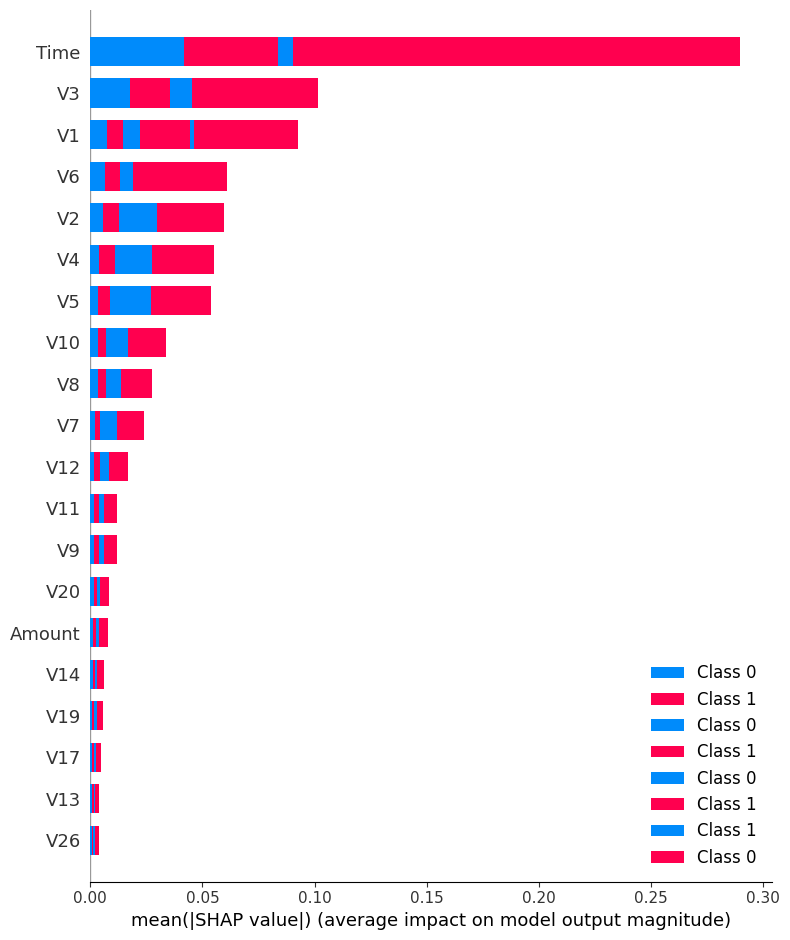

In [10]:
# Step 4: Explain the models using SHAP
evaluator.explain_model(trained_mlp, model_name="MLP")
evaluator.explain_model(trained_cnn, model_name="CNN")
evaluator.explain_model(trained_rnn, model_name="RNN")
evaluator.explain_model(trained_lstm, model_name="LSTM")